In [2]:
import wget
import gzip
import sys
import os
import platform
import json
import pickle
import subprocess
import multiprocessing as mp
from collections import OrderedDict, defaultdict
import redis

import numpy as np
import pandas
from Bio.Seq import Seq
import dendropy
from matplotlib import pyplot as plt

from EAGLE.constants import EAGLE_logger
from EAGLE.lib.seqs import shred_seqs, dump_fasta_dict, load_fasta_to_dict
from EAGLE.lib.phylo import PhyloTree, compare_trees
from EAGLE.lib.alignment import MultAln

In [27]:
!pip install git+https://github.com/loven-doo/EAGLE.git@dev --upgrade

  Cloning https://github.com/loven-doo/EAGLE.git (to revision dev) to /tmp/pip-req-build-O7LFqF
Branch dev set up to track remote branch dev from origin.
Switched to a new branch 'dev'
  Running setup.py bdist_wheel for EAGLE ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-rj3eKu/wheels/d9/64/81/24ad9bd2aa49b45da7cb44955cef1a75d5708726fd75060d44
Successfully built EAGLE
  Found existing installation: EAGLE 0.20.3
    Uninstalling EAGLE-0.20.3:
      Successfully uninstalled EAGLE-0.20.3


In [11]:
fams_dict = json.load(open("EAGLEdb/bacteria/bact_fam.json"))
genera_num_list = list()
sp_num_list = list()
strain_num_list = list()
special_keys = ("16S_rRNA_tree", "16S_rRNA_tsv", "16S_rRNA_fasta", "blastdb", "repr_profile", "fam_fna", "chr_id")
fam_num = 0
for fam_name in fams_dict.keys():
    if fam_name in ("db_dir", "db_repr_profiles", "fam_fna"):
        continue
    fam_num += 1
    genera_num = 0
    sp_num = 0
    strain_num = 0
    for genus in fams_dict[fam_name].keys(): 
        if genus in special_keys:
            continue
        genera_num += 1
        for sp in fams_dict[fam_name][genus].keys():
            sp_num += 1
            for strain in fams_dict[fam_name][genus][sp].keys():
                strain_num += 1
    genera_num_list.append(genera_num)
    sp_num_list.append(sp_num)
    strain_num_list.append(strain_num)
    if genera_num >= 4 and strain_num >= 8:
        print(fam_name)

print(fam_num)
print(sum(genera_num_list))
print(sum(sp_num_list))    
print(sum(strain_num_list))    

Erwiniaceae
Rhodospirillaceae
Helicobacteraceae
Halomonadaceae
Alteromonadaceae
Sphingomonadaceae
Rhodobacteraceae
Pseudonocardiaceae
Bradyrhizobiaceae
Burkholderiaceae
Vibrionaceae
Oxalobacteraceae
Comamonadaceae
Enterobacteriaceae
Alcaligenaceae
Flavobacteriaceae
Erythrobacteraceae
Micrococcaceae
Microbacteriaceae
Planococcaceae
Ectothiorhodospiraceae
Spirochaetaceae
Acetobacteraceae
Peptococcaceae
Morganellaceae
Lachnospiraceae
Xanthomonadaceae
Cytophagaceae
Bifidobacteriaceae
Thermaceae
336
750
1388
1399


In [13]:
def list_to_txt(in_list, txt_path):
    f = open(txt_path, 'w')
    for elm in in_list:
        f.write(str(elm)+"\n")
    f.close()
    

list_to_txt(strain_num_list, "strain_num.txt")

In [40]:
gtf_df = pandas.read_csv("runs/example_genomes/erwin_result/NC_013961.fasta.gtf", sep="\t")
gtf_df["uniformity_std"] = gtf_df.apply(lambda row: json.loads(row["attribute"])["p_uniformity"], axis=1)  # rename "p_uniformity" to "uniformity_std"
gtf_df["phylo_diff"] = gtf_df.apply(lambda row: json.loads(row["attribute"])["phylo_diff"], axis=1)

In [60]:
gtf_df = gtf_df[["uniformity_std", "phylo_diff"]].apply(lambda row: None if np.isnan(row["uniformity_std"]) or np.isnan(row["phylo_diff"]) else row, axis=1)

Text(0,0.5,'ORFs number')

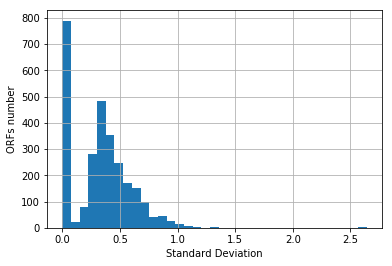

In [61]:
ax = pandas.Series(filter(lambda x: not np.isnan(x), gtf_df["uniformity_std"])).hist(bins=35);
ax.set_xlabel("Standard Deviation")
ax.set_ylabel("ORFs number")

Text(0,0.5,'ORFs number')

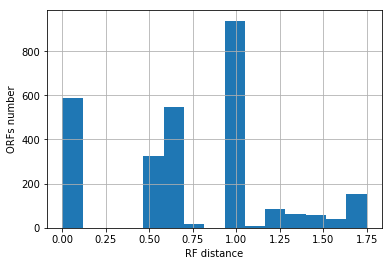

In [62]:
ax = pandas.Series(filter(lambda x: not np.isnan(x), gtf_df["phylo_diff"])).hist(bins=15);
ax.set_xlabel("RF distance")
ax.set_ylabel("ORFs number")

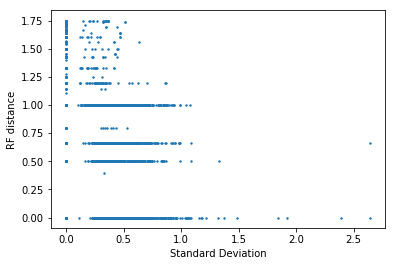

In [68]:
_df = gtf_df[[]]
plt.scatter(x=pandas.Series(filter(lambda x: not np.isnan(x), gtf_df["uniformity_std"])),
            y=pandas.Series(filter(lambda x: not np.isnan(x), gtf_df["phylo_diff"])),
            s=2)
plt.xlabel("Standard Deviation")
plt.ylabel("RF distance")
plt.show()

In [78]:
proc_bact = json.load(open("processed_bact.json"))
resp_bact = json.load(open("responsed_bacteria.json"))
n_t = 0
n = 0
for i in range(len(resp_bact)):
    if resp_bact[i] == proc_bact[i]:
        n_t += 1
    n += 1
print(100.0*float(n_t)/float(n))

13.1661442006


In [6]:
fams_dict["db_repr_profiles"]

u'EAGLEdb/bacteria/db_repr_profiles'

In [24]:
tree = dendropy.Tree.get_from_string("((Aa,B_b),(C_c,D_d));", schema="newick")
print(tree.nodes())
print(tree.find_node_with_taxon_label("Aa"))
print(tree.as_ascii_plot())
tree.prune_taxa_with_labels(["B b"])
print(tree.as_string(schema='newick'))
print(tree.as_ascii_plot())
nodes = tree.nodes()
node = nodes[0]
taxon = node.taxon
print(taxon)
len(tree.leaf_nodes())

[<Node object at 0x7ffad412c2d0: 'None' (None)>, <Node object at 0x7ffad44823d0: 'None' (None)>, <Node object at 0x7ffad41b2850: 'None' (<Taxon 0x7ffad41b2910 'Aa'>)>, <Node object at 0x7ffad41b2a50: 'None' (<Taxon 0x7ffad4257890 'B b'>)>, <Node object at 0x7ffad42578d0: 'None' (None)>, <Node object at 0x7ffad4257750: 'None' (<Taxon 0x7ffad4257c10 'C c'>)>, <Node object at 0x7ffad4257c90: 'None' (<Taxon 0x7ffad4257d10 'D d'>)>]
<Node object at 0x7ffad41b2850: 'None' (<Taxon 0x7ffad41b2910 'Aa'>)>
                                     /------------------------------------- Aa 
/------------------------------------+                                         
|                                    \------------------------------------- B b
+                                                                              
|                                    /------------------------------------- C c
\------------------------------------+                                         
                  

3

In [110]:
tree = dendropy.Tree.get(path="btax_tree.nwk", schema="newick")
print(tree.nodes())
print(tree.as_string("newick"))
print(tree.find_node_with_taxon_label("new_label"))
node_to_rename = tree.find_node_with_taxon_label("Cenet  x 2")
print(node_to_rename)
node_to_rename.taxon.label = "new_label"
print(tree.find_node_with_taxon_label("new_label"))

[<Node object at 0x7fcf814e4550: 'None' (None)>, <Node object at 0x7fcf814e45d0: 'None' (None)>, <Node object at 0x7fcf815afd90: 'None' (None)>, <Node object at 0x7fcf815afe10: 'None' (None)>, <Node object at 0x7fcf815afe90: 'None' (None)>, <Node object at 0x7fcf815aff10: 'None' (None)>, <Node object at 0x7fcf815aff90: 'None' (<Taxon 0x7fcf815a7050 'seend  x  '>)>, <Node object at 0x7fcf815a7090: 'None' (None)>, <Node object at 0x7fcf815a7110: 'None' (None)>, <Node object at 0x7fcf815a7190: 'None' (None)>, <Node object at 0x7fcf815a7210: 'None' (None)>, <Node object at 0x7fcf815a7290: 'None' (None)>, <Node object at 0x7fcf815a7310: 'None' (None)>, <Node object at 0x7fcf815a7390: 'None' (None)>, <Node object at 0x7fcf815a7410: 'None' (<Taxon 0x7fcf815a7490 'Cenet  x 2'>)>, <Node object at 0x7fcf815a74d0: 'None' (None)>, <Node object at 0x7fcf815a7550: 'None' (<Taxon 0x7fcf815a75d0 'Cenet  x 3'>)>, <Node object at 0x7fcf815a7610: 'None' (<Taxon 0x7fcf815a7690 'Cenet  x 4'>)>, <Node objec

In [4]:
phylo_tree1 = PhyloTree.load_tree(tree_file="runs/example_genomes/tmp/tree1_1.nwk")
print(phylo_tree1.tree.as_ascii_plot())
phylo_tree2 = PhyloTree.load_tree(tree_file="runs/example_genomes/tmp/tree2_1.nwk")
print(phylo_tree2.tree.as_ascii_plot())
#phylo_tree2.dump_tree("to_comp2.1.nwk")
compare_trees(phylo_tree1=phylo_tree1, phylo_tree2=phylo_tree2)

/-------------- Pantoea_ananatis_LMG_20103                                     
|                                                                              
|          /--- Buchnera_aphidicola_(Aphis_glycines)                           
|      /---+                                                                   
|      |   \--- Erwinia_amylovora_CFBP1430                                     
|  /---+                                                                       
+  |   |   /--- Wigglesworthia_glossinidia_endosymbiont_of_Glossina_brevipalpis
|--+   \---+                                                                   
|  |       \--- Tatumella_citrea                                               
|  |                                                                           
|  \----------- Erwinia_billingiae_Eb661                                       
|                                                                              
\-------------- Pantoea_alhagi          

8

In [5]:
taxa = dendropy.TaxonNamespace()
tree1 = phylo_tree1.tree
tree1.reroot_at_midpoint()
print(tree1.as_ascii_plot())
print(tree1.as_string(schema='newick'))

          /---- Wigglesworthia_glossinidia_endosymbiont_of_Glossina_brevipalpis
/---------+                                                                    
|         \---- Tatumella_citrea                                               
|                                                                              
|         /---- Buchnera_aphidicola_(Aphis_glycines)                           
+---------+                                                                    
|         \---- Erwinia_amylovora_CFBP1430                                     
|                                                                              
|    /--------- Erwinia_billingiae_Eb661                                       
\----+                                                                         
     |    /---- Pantoea_ananatis_LMG_20103                                     
     \----+                                                                    
          \---- Pantoea_alhagi          

In [3]:
!export PATH=$PATH:/home/loven-doo/tools/bin && ftreedist tmp/to_comp.nwk tmp/comp.res -dtype s

Calculate distances between trees

Output written to file "tmp/comp.res"

Done.



In [91]:
names_to_remain = set(phylo_tree1.names) & set(phylo_tree2.names)
print(names_to_remain)
while True:
    try:
        phylo_tree2.tree.collapse(lambda c: c.name in (set(phylo_tree2.names) - names_to_remain))
    except ValueError:
        break
phylo_tree2.names

set(['Plautia_stali_symbiont', 'Kosakonia_cowanii', 'Cronobacter_sakazakii'])


['Plautia_stali_symbiont', 'Cronobacter_sakazakii', 'Kosakonia_cowanii']

In [13]:
mult_aln = MultAln.load_alignment(aln_fasta_path="runs/NC_011750_576818-577147_mult_aln.fasta")
pv = mult_aln.improve_aln(inplace=False).estimate_uniformity()
if np.isnan(dict()):
    print("OK")
print(type(pv))

('cons_cols_by_windows', array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0]))


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [2]:
from EAGLE.eag_location_explorer import get_btax

#in_fasta = "EAGLEdb/bacteria_test/GCF_002005165.1_ASM200516v1_genomic.fna"
in_fasta = "EAGLEdb/bacteria_test/Acetoanaerobium_sticklandii_16S_rRNA.fasta"
db_json = "EAGLEdb/bacteria/bact_fam.json"
db_info = json.load(open(db_json))
get_btax(in_fasta,
         db_info["db_repr_profiles"],
         btax_names=db_info.keys(),
         hmmer_inst_dir="/home/loven-doo/tools/bin",
         remove_scan_out=False)

2018-05-23 00:02:19,148 - INFO - hmmscan started
2018-05-23 00:02:19,153 - INFO - hmmscan finished


{'EAGLEdb/bacteria_test/Acetoanaerobium_sticklandii_16S_rRNA': u'Peptostreptococcaceae'}

In [17]:
fna_dict = load_fasta_to_dict("check_bactdb/GCA_003369875.1_ASM336987v1_genomic.fna")
shredded_fna_dict = shred_seqs(fna_dict)

fasta_to_scan_dict = OrderedDict()
for seq_id in shredded_fna_dict:
    i = 1
    for seq in shredded_fna_dict[seq_id]:
        fasta_to_scan_dict[seq_id+"_"+str(i)] = seq
        i += 1
dump_fasta_dict(fasta_dict=fasta_to_scan_dict, fasta_path="check_bactdb/GCA_003369875.1_ASM336987v1_genomic.fna.shr")

In [107]:
def load_phylip_dist_matrix(matrix_path):
    matr_f = open(matrix_path)
    lines_dict = OrderedDict()
    seqs_list = list()
    for line_ in matr_f:
        line = None
        line = line_.strip()
        if not line:
            continue
        line_list = filter_list(line.split())
        if len(line_list) == 1:
            continue
        seqs_list.append(line_list[0])
        lines_dict[line_list[0]] = line_list[1:]
    matrix = pandas.DataFrame.from_dict(data=lines_dict, orient='index')
    matrix.columns = seqs_list
    return matrix


def filter_list(in_list):
    filtered_list = list()
    for elm_ in in_list:
        elm = None
        elm = elm_.strip()
        if elm:
            filtered_list.append(elm)
    return filtered_list
    
    
matr_f_path = 'dist_matr.ph'
dist_matrix = load_phylip_dist_matrix(matr_f_path)
print sum(map(float, list(dist_matrix.loc['Seq1abcdef'])))
print(dist_matrix.index)

0.379063
Index([u'Seq1abcdef', u'Seq2abcd', u'Seq3abcdef'], dtype='object')


In [207]:
bacteria_json_f = open("EAGLEdb/bacteria/bacteria.json")
bacteria_info_list = json.load(bacteria_json_f)
bacteria_json_f.close()
analyzed_bacteria = mp.Manager().dict()
for bacterium_info in bacteria_info_list:
    if os.path.exists(bacterium_info[u'16S_rRNA_file']):
        analyzed_bacteria[bacterium_info[u'strain'].replace("_", " ")] = True
analyzed_bacteria_f = open("analyzed_bacteria.p", 'wb')
pickle.dump(analyzed_bacteria, analyzed_bacteria_f)
analyzed_bacteria_f.close()

In [213]:
analyzed_bacteria["Buchnera_aphidicola_str._Bp_(Baizongia_pistaciae)".replace("_", " ")]

True

In [119]:
test_dict = {"k1": 2, "k2": 1, "k3": 3}
sorted(test_dict.items(), key=lambda x: x[1])

[('k2', 1), ('k1', 2), ('k3', 3)]

In [132]:
test_dict = {"set1": {"k1": 2, "k2": 1, "k3": 3}, 
             "set2": {"k4": 3, "k5": 6, "k6": 2}}
for key in test_dict.keys():
    test_dict[key] = sorted(test_dict[key].items(), key=lambda x: x[1])
print test_dict
falsh_dict = {"k1": "a", "k2": "b", "k3": "c", "k4": "d", "k5": "e", "k6": "f"}
trans_dict = {"k1": "set1", "k2": "set1", "k3": "set1", "k4": "set2", "k5": "set2", "k6": "set2"}
filter(lambda x: x[0] == test_dict[trans_dict[x[0]]][0][0], falsh_dict.items())


{'set1': [('k2', 1), ('k1', 2), ('k3', 3)], 'set2': [('k6', 2), ('k4', 3), ('k5', 6)]}


[('k2', 'b'), ('k6', 'f')]

In [141]:
print ((None, None), (None, None))

((None, None), (None, None))


In [18]:
pd_dict = {"Key1": {"A": 4, "B": 2},
           "Key2": {"A": 3, "B": 4}}
df1 = pandas.DataFrame.from_dict(data=pd_dict, orient="index")
df2 = pandas.DataFrame(pd_dict.values())
print(df2)
df2.sort_values("B")

   A  B
0  3  4
1  4  2


,A,B
1,4,2
0,3,4


In [159]:
d = {"k1": 1, "k2": 2}
d = defaultdict(int)
d["k1"] = 1
d["k2"] = 2
print(d["A"])
if d.pop("k1") == 1:
    print 1
a = d.pop("A")
print k1, a, d.keys()

0
1
1 0 ['k2']


In [168]:
def get_tree_from_dict(input_dict, stop_level=2):
    tree = dict()
    if stop_level == 1:
        return input_dict.keys()
    for key in input_dict.keys():
        tree[key] = get_tree_from_dict(input_dict[key], stop_level=stop_level-1)
    return tree

d = {"k1": {"k3": {"k5": 5,
                   "k6": 6},
            "k4": {"k7": 7,
                   "k8": 8}},
     "k2": {"k9": {"k11": 11,
                   "k12": 12},
            "k10": {"k13": 13,
                    "k14": 14}}}
get_tree_from_dict(d, 3)

{'k1': {'k3': ['k6', 'k5'], 'k4': ['k8', 'k7']},
 'k2': {'k10': ['k13', 'k14'], 'k9': ['k12', 'k11']}}

In [177]:
dicts_list = [{"col1": 1, "col2": 2, "col3": 3},
              {"col1": 4, "col2": 5, "col3": 6},
              {"col1": 7, "col2": 8, "col3": 9}]
appl_df = pandas.DataFrame(dicts_list)
print(appl_df)
list(appl_df.apply(lambda x: (x["col1"], x["col2"]) if x["col3"] > 5 else None, axis=1))

   col1  col2  col3
0     1     2     3
1     4     5     6
2     7     8     9


[None, (4, 5), (7, 8)]

In [92]:
def dump_phylip_dist_matrix(dist_matrix, matrix_path):
    matr_f = open(matrix_path, 'w')
    matr_f.write("    %s\n" % len(dist_matrix.columns))
    for seq in dist_matrix.index:
        num_spaces_to_add = 10 - len(seq)
        spaces_to_add = [" " for i in range(num_spaces_to_add)]
        matr_f.write("%s %s\n" % (seq+"".join(spaces_to_add), " ".join(dist_matrix.loc[seq].tolist())))
    matr_f.close()
    

dump_phylip_dist_matrix(dist_matrix, "dumped_matrix.ph")

In [ ]:
def reduce_seq_names(fasta_dict, num_letters=10, num_words=4):
    if num_letters < 6:
        print("Number of letters must be at least 6")
        return 1
    if num_words < 2:
        print("Number of words must be at least 2")
        return 1
    splitters_repl = {"\t": " ",
                      ",": " ",
                      ";": " ",
                      ".": " ",
                      ":": " ",
                      "|": " ",
                      "/": " ",
                      "\\": " "}
    parts_size_list = get_part_size_list(num_letters, num_words)
    reduced_fasta_dict = dict()
    seq_names_dict = dict()
    for seq_name in fasta_dict.keys():
        reduced_seq_name = None
        seq_name_list = filter_list("".join([splitters_repl.get(s, s) for s in seq_name]).split())
        parts = list()
        for i in range(num_words):
            try:
                parts.append(seq_name_list[i][:parts_size_list[i]])
            except IndexError:
                break
        reduced_seq_name = "".join(parts)
        res_len = num_letters - len(reduced_seq_name)
        un_num = 1
        un_fix = get_un_fix(un_num, res_len)
        while seq_names_dict.get(reduced_seq_name+un_fix, None):
            un_fix = None
            un_num += 1
            un_fix = get_un_fix(un_num, res_len)
        reduced_fasta_dict[reduced_seq_name+un_fix] = fasta_dict[seq_name]
        seq_names_dict[reduced_seq_name+un_fix] = seq_name 
    return reduced_fasta_dict, seq_names_dict


def get_part_size_list(num_letters, num_words):
    if num_letters == 6: 
        return [2, 3]
    if num_letters == 7:
        if num_words >= 3:
            return [2, 3, 1]
        else:
            return [2, 3]
    if num_letters == 8:
        if num_words >= 4:
            return [2, 3, 1, 1]
        elif num_words == 3:
            return [3, 3, 1]
        else:
            return [3, 3]
    if num_letters == 9:
        if num_words >= 4:
            return [3, 3, 1, 1]
        elif num_words == 3:
            return [3, 3, 1]
        else:
            return [3, 4]
    if num_letters == 10:
        if num_words >= 4:
            return [3, 4, 1, 1]
        elif num_words == 3:
            return [3, 4, 1]
        else:
            return [4, 4]
    if num_letters >= 11:
        if num_words >= 4:
            return [3, 4, 1, 1]
        elif num_words == 3:
            return [4, 4, 1]
        else:
            return [4, 5]


def get_un_fix(un_num, fix_len):
    un_codes = ["_", '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E']
    # 'N' - undefined (num duplicates is bigger than len(un_codes))
    if fix_len == 1:
        try:
            return un_codes[un_num-1]
        except IndexError:
            return 'N'
    elif fix_len == 0:
        return ""
    elif un_num <= len(un_codes):
        return un_codes[0] + get_un_fix(un_num, fix_len-1)
    else:
        filled_rank = len(un_codes)**(fix_len-1)
        return un_codes[un_num//filled_rank - 1] + get_un_fix(un_num%filled_rank, fix_len-1)
    

fasta_dict = {"seq1abc_defghi jkhhg": "ACGTTGCGGTAA", 
              "seq2hgft asdad.fdggjh fgjgh fgjhd": "GGTTAAG",
              "seq3hgft asdad fdggjh\fgjgh fkn": "GGTTAAG"}
reduce_seq_names(fasta_dict)

In [5]:
seq = "ACGTK!C"
str(Seq(seq).reverse_complement())

'G!MACGT'